# NLP Disaster Tweets

This project is an exploration of deep learning techniques in the natural language processing, including: Recurrent Neural Networks (RNN) and Long Short Term Memory (LSTM) based models.

---

This project derives from the Kaggle competition with the name Natural Language Processing with Disaster Tweets, found here: https://www.kaggle.com/c/nlp-getting-started/overview

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
  - 1.1. [Text Corpus](#data)
  - 1.2. [Kaggle Information](#kaggle)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)
  - 3.1. [First Looks](#firstlook)
  - 3.2. [Missing Data](#missingdata)
  - 3.3. [Text Cleanup](#textclean)
  - 3.4. [Checking for Duplicate Entries](#duplicates)
- 4.[**Exploratory Data Analysis (EDA)**](#eda)
- 5.[**Models and Embedding**](#models)
  - 5.1. [Baseline Models](#baseline)
  - 5.2. [Word Embedding](#embed)
  - 5.3. [Unsupervised Model](#unsuper)
    - 5.3.1. [Non-Negative Matrix Factorization (NMF)](#nmf)
  - 5.4. [Deep Learning Models](#deep)
  - 5.4.1. [Recurrent Neural Network (RNN)](#rnn)
  - 5.4.2. [Long Short Term Memory (LSTM)](#lstm)
- 6.[**Results**](#results)
- 7.[**Conclusion - Kaggle Submission Test Set**](#conclusion)
  - 7.1. [Possible Areas for Improvement](#improvements)

- [**Appendix A - Online References**](#appendixa)

## 1. Data Source Information <a name="datasource"></a>

---


### 1.1. Text Corpus: <a name="data"></a>

Public dataset of tweets from Twitter (X) in which some are about real disasters, and some are not.

This dataset was created by the company **figure-eight** and originally shared on their ‘Data For Everyone’ website (https://www.appen.com/data-for-everyone). <- (Dead link, need to check archives (waybackmachine).)

**Data Info:**
- 10,876 Tweets

- **Feature Information**
    - **id** - Unique identifier for each tweet.
    - **text** - Text of the tweet.
    - **location** - Location the tweet was sent from.
    - **keyword** - Keyword from the tweet.
    - **target** - Denotes whether a tweet is about a real disaster (1) or not (0).

### 1.2. Kaggle Information: <a name="kaggle"></a>

#### Description:

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. 

#### Evaluation:

The evaluation metric for this competition is F1 Score. The sample_submission.csv file shows the format required for submission. The file should contain a header with column names and a tuple of tweet ID and binary target class (0 not a disaster, 1 is a disaster).

#### Citation: 

Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started

###### [Back to Table of Contents](#toc)

## 2. Setup <a name="setup"></a>

---

In [706]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

import re
import itertools
from nltk.corpus import stopwords
# nltk.download('stopwords') # Needed for first run.

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.svm import SVC
import xgboost as xgb

###### [Back to Table of Contents](#toc)

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

In [707]:
print(f"Python version: {sys.version}")

packages = [pd, np, sns, re, sklearn, xgb]
for package in packages:
    print(f"{str(package).partition('from')[0]} using version: {package.__version__}")

Python version: 3.11.9 (main, Apr  2 2024, 08:25:04) [Clang 15.0.0 (clang-1500.3.9.4)]
<module 'pandas'  using version: 2.1.4
<module 'numpy'  using version: 1.26.4
<module 'seaborn'  using version: 0.13.2
<module 're'  using version: 2.2.1
<module 'sklearn'  using version: 1.3.2
<module 'xgboost'  using version: 2.0.3


###### [Back to Table of Contents](#toc)

### 2.2. Importing the Data: <a name="dataimport"></a>

In [708]:
# Set directories
current_wdir = os.getcwd()
data_folder = current_wdir + '/Data/'

In [709]:
# Add and sort all filenames from each folder path.
file_path = [f'{data_folder}/{file}' for file in os.listdir(data_folder) if '.csv' in file]
file_path = sorted(file_path)

# Iterate through filenames and add them to dataframe.
train = pd.read_csv(data_folder + '/train.csv')
X_test = pd.read_csv(data_folder + '/test.csv')
sample_y_test = pd.read_csv(data_folder + '/sample_submission.csv')

###### [Back to Table of Contents](#toc)

## 3. Data Preprocessing <a name="datapre"></a>

---

### 3.1. First Looks: <a name="firstlook"></a>

Print out some basic information about the training and testing sets.

In [710]:
print('-------------------------------------\nTrain\n-------------------------------------')
display(train)
print(train.dtypes)
print('\n------------------------------------\nTest\n------------------------------------')
print(X_test.columns.to_list())
print(X_test.shape)

-------------------------------------
Train
-------------------------------------


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

------------------------------------
Test
------------------------------------
['id', 'keyword', 'location', 'text']
(3263, 4)


Let's take a look at the `keyword` and `location` columns a little closer as it seems many of the tweets are missing this information.

In [711]:
train[~train.keyword.isna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


In [712]:
train[~train.location.isna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


To keep all future plots clear and consistent, a color map dictionary will map the classes to a color. 

In [713]:
# Build custom color map for consistent label visualization.
class_cmap = {'Not Disaster' : '#012A36',
              'Disaster' : '#D16666'}

Let's also add a categorical variable column for 'Disaster' (1) and 'Not_Disaster' (0) for visualization convenience.

In [714]:
target_map = {0 : 'Not Disaster',
              1: 'Disaster'}
train['target_str'] = train.target.map(target_map)

Let's quickly check the balance of the target class label distribution among the data.

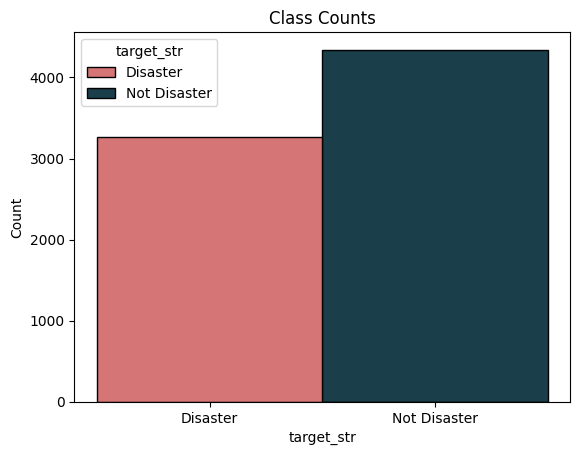

In [715]:
sns.histplot(train, x = 'target_str', hue = 'target_str', palette = class_cmap, alpha = 0.9)
plt.title('Class Counts')
plt.show()

These are fairly even and since our evaluation metric will be F1-Score, and the train/test split has been done for us already, this is fine. No class balancing will be done for now.

Let's randomly sample a few tweets to get a better idea what sort of text processing needs to be done before token vectorization. 

In [716]:
# Choose random text to display a section of.
print(train.text[10], '--', train.target[10])
print(' -  -  - ')
print(train.text[50], '--', train.target[50])
print(' -  -  - ')
print(train.text[100], '--', train.target[100])
print(' -  -  - ')
print(train.text[150], '--', train.target[150])
print(' -  -  - ')
print(train.text[200], '--', train.target[200])

Three people died from the heat wave so far -- 1
 -  -  - 
Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k -- 1
 -  -  - 
.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad -- 1
 -  -  - 
@mickinyman @TheAtlantic That or they might be killed in an airplane accident in the night a car wreck! Politics at it's best. -- 0
 -  -  - 
HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPONDING WITH DUAL SIRENS ANDÛ_ https://t.co/SeK6MQ6NJF -- 0


Plenty of variety of language and grammar on display here. 

- Words like 'people', 'died', and the bigram 'people died' seem like they will be important.
- We see an all capital letter tweet which is not labeled as a real disaster.
- 2/3 tweets with hyperlinks are real disasters.
- Tagging a user could potentially skew to one class.
- Hashtags also might be useful in predictions.

Careful consideration will be taken during the text processing stage to not eliminate too much information that may help the models with predictions.

###### [Back to Table of Contents](#toc)

### 3.2. Missing Data: <a name="missingdata"></a>

Now, we should ensure there aren't any tweets with completely missing data.

In [717]:
train.isna().sum()

id               0
keyword         61
location      2533
text             0
target           0
target_str       0
dtype: int64

In [718]:
display(X_test.isna().sum())

id             0
keyword       26
location    1105
text           0
dtype: int64

Looks good. 

Also, it's expected that not all tweets will have keywords or locations. 

We will deal with those NaNs now.

In [719]:
train.keyword = train.keyword.where(~train.keyword.isna(), other = 'na')
train.location = train.location.where(~train.location.isna(), other = 'na')
print(train.isna().sum())

id            0
keyword       0
location      0
text          0
target        0
target_str    0
dtype: int64


In [720]:
X_test.keyword = X_test.keyword.where(~X_test.keyword.isna(), other = 'na')
X_test.location = X_test.location.where(~X_test.location.isna(), other = 'na')
print(X_test.isna().sum())

id          0
keyword     0
location    0
text        0
dtype: int64


###### [Back to Table of Contents](#toc)

### 3.3. Text Cleanup: <a name="textclean"></a>

It's very important to decide what kinds of text processing will benefit or hurt our planned models. For instance, since we are planning on using deep learning in this project something like an LSTM-based model may or may not benefit from removing stop words (described below), but something like a simpler RNN might benefit. Also, as was touched on above, removing certain special characters carte blanche is probably detrimental because of the way twitter and tweets are used (e.g. removing # or @ would possible remove an important flag to our model that could have predictive power).

It's also worth noting that because we are dealing with tweets which are short-form texts (140 or 280 characters depending on the year) removing words could potentially drastically affect the corpus.

Here I will go through each typical processing technique and decide individually whether it is worth implementing.

**Pre-processing methods for NLP:**
1. Set all letters to lowercase. 
    - **Yes**, will perform: This will reduce computation because words will only show up once in vocabulary invariant of capitalization. *However with a suitably large dataset this would be interesting to see if all caps tweets correlated to a disaster.*
2. Remove special characters. 
    - **Yes**, will perform*: **Will leave in # and @ since it is domain specific in this case.** This reduces redundancy for words that include special characters.
3. Remove punctuation. 
    - **Yes**, will perform.
4. Remove extra spaces. 
    - **Yes**, will perform.
5. Remove "stop words" (e.g. `the`, `is`, `a`, `an`, `for`, etc). 
    - **No**, will not perform: Since tweets are short we will leave this for now unless performance is noticeably low.
6. Tokenize words (e.g. `amazingly few discotheques provide jukeboxes` $\rightarrow$ `[amazingly], [few], [discotheques], [provide], [jukeboxes]`). 
    - **Yes**, will perform.
7. Lammatize words, reducing words to their roots (e.g. `striking` $\rightarrow$ `strike` or `strikes` $\rightarrow$ `strike`). 
    - **No**, will not perform: Probably wouldn't hurt, but I believe the corpus to be large enough it should be negligible and deep learning should catch extra context without.
8. Deal with hyperlinks. 
    - **No**: If some hyperlinks match, it may help train the model to identify that disaster. However, another technique could be to replace all hyperlinks with a unique token that just identifies a hyperlink as a hyperlink, not specific. This could prove useful if hyperlinks correlate to one target class more than the other.

In [721]:
def clean_corpus(df, column):
    df['lower'] = df[column].str.lower()
    # Remove hyphens and replace with space.
    df['hyphen'] = df['lower'].apply(lambda x: re.sub(r'-', ' ', x))
    # Remove anything that isn't a letter, number, space, hashtag #, or tag @.
    df['alpha_only'] = df['hyphen'].apply(lambda x: re.sub(r'[^ a-zA-Z0-9@#]+', '', x))
    # Remove any extra spaces.
    df['double_spaces'] = df['alpha_only'].apply(lambda x: re.sub(r'\s{2,}', ' ', x))
    # Remove stop words.
    stops = set(stopwords.words('english')) # Set lookup is faster.
    df['cleaned'] = df['double_spaces'].apply(lambda x: ' '.join([word for word in x.split() if word not in stops]))
    
    return

Both training and test sets will be processed with the same function.

Also, let's add the keyword and location to the beginning of the text so we can incorporate those into the data at the same time as the main body of the tweets.

In [722]:
train.text = train.location + ' ' + train.keyword + ' ' + train.text

# Apply text processing function.
clean_corpus(train, 'text')
clean_corpus(X_test, 'text')

Now let's see those same examples from earlier, but processed. 

Also, we can put the unprocessed and processed versions of a text into their each `set()` and perform subtraction to find the difference between the two -- showing the changes made.

In [723]:
print('Processed:', train.cleaned[10], '--', train.target[10])
print('Original: ', train.text[10], '--', train.target[10])
print('Set Difference Example:', set(train.text[10].split()) - set(train.cleaned[10].split()))
print(' -  -  - ')
print('Processed:', train.cleaned[50], '--', train.target[50])
print('Original: ', train.text[50], '--', train.target[50])
print('Set Difference Example:', set(train.text[50].split()) - set(train.cleaned[50].split()))
print(' -  -  - ')
print('Processed:', train.cleaned[100], '--', train.target[100])
print('Original: ', train.text[100], '--', train.target[100])
print('Set Difference Example:', set(train.text[100].split()) - set(train.cleaned[100].split()))
print(' -  -  - ')
print('Processed:', train.cleaned[150], '--', train.target[150])
print('Original: ', train.text[150], '--', train.target[150])
print('Set Difference Example:', set(train.text[150].split()) - set(train.cleaned[150].split()))
print(' -  -  - ')
print('Processed:', train.cleaned[200], '--', train.target[200])
print('Original: ', train.text[200], '--', train.target[200])
print('Set Difference Example:', set(train.text[200].split()) - set(train.cleaned[200].split()))

Processed: na na three people died heat wave far -- 1
Original:  na na Three people died from the heat wave so far -- 1
Set Difference Example: {'so', 'from', 'the', 'Three'}
 -  -  - 
Processed: sheffield township ohio ablaze deputies man shot brighton home set ablaze httptcogwnrhmso8k -- 1
Original:  Sheffield Township, Ohio ablaze Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k -- 1
Set Difference Example: {'Sheffield', 'Man', 'http://t.co/gWNRhMSO8k', 'before', 'Deputies:', 'Township,', 'Brighton', 'Ohio'}
 -  -  - 
Processed: uk accident @norwaymfa #bahrain police previously died road accident killed explosion httpstcogfjfgtodad -- 1
Original:  UK accident .@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad -- 1
Set Difference Example: {'they', 'by', 'a', 'were', 'in', 'not', '#Bahrain', '.@NorwayMFA', 'had', 'https://t.co/gFJfgTodad', 'UK'}
 -  -  - 
Processed: new mexico usa airpla

Great it looks like everything worked.

You will notice that the hyperlinks are quite different now, but since the same changes were made to all of them they still represent a unique hyperlink.

Now that the text has been processed, tokenizing the words in the tweets becomes trivial.

In [724]:
def tokenizer(df):
    df['tokens'] = df['cleaned'].apply(lambda x: x.split())
    
    return

In [725]:
tokenizer(train)
tokenizer(X_test)

print(train.tokens[100])

# Here we can output all tweets that contain the word 'dead'.
train.tokens[train.tokens.apply(lambda x: 'dead' in x)]

['uk', 'accident', '@norwaymfa', '#bahrain', 'police', 'previously', 'died', 'road', 'accident', 'killed', 'explosion', 'httpstcogfjfgtodad']


41      [na, ablaze, outside, youre, ablaze, alivebut,...
155     [us, resident, airplane20accident, usama, bin,...
463     [flg, attack, heart, attack, thought, goat, de...
988     [39982988, 75261624, body20bagging, @fuckyeahc...
1412    [50, queanbeyan, 50, sydney, casualties, @flyo...
                              ...                        
7423    [na, wounded, police, officer, wounded, suspec...
7426    [na, wounded, police, officer, wounded, suspec...
7429    [england, united, kingdom, wounded, #latestnew...
7430    [usa, wounded, abc, news, police, officer, wou...
7434    [paterson, new, jersey, wounded, police, offic...
Name: tokens, Length: 95, dtype: object

Another check on the processing step is to check if there are any tokens that are empty whitespace. These should have been dealt with during one of the regex preprocessing steps.

In [726]:
# Check to ensure no empty tokens.
train.tokens[train.tokens.apply(lambda x: ' ' in x)]

Series([], Name: tokens, dtype: object)

###### [Back to Table of Contents](#toc)

### 3.4. Checking for Duplicate Entries: <a name="duplicates"></a>

Finally, we need to ensure there aren't any duplicate entries in the data.

In [727]:
# Training Set
print('Duplicates Found:', train.text.duplicated().sum())
print('DF Shape:', train.shape)

drop_idx = train[train.text.duplicated()].index
train = train.drop(drop_idx, axis = 0)

print('Duplicates Found:', train.text.duplicated().sum())
print('DF Shape:', train.shape)

Duplicates Found: 61
DF Shape: (7613, 12)
Duplicates Found: 0
DF Shape: (7552, 12)


110 tweets showed up as being duplicates in the training data. These have now been removed.

In [728]:
# Test
print('Duplicates Found:', X_test.text.duplicated().sum())
print('DF Shape:', X_test.shape)

Duplicates Found: 20
DF Shape: (3263, 10)


Unfortunately, there are also 20 duplicate tweets in the testing set. Since the testing set was created for us and to be submitted into Kaggle for scoring, we can't fix this issue.

###### [Back to Table of Contents](#toc)

## 4. Exploratory Data Analysis (EDA) <a name="eda"></a>

---

Now that the text has been processed, we are ready to perform EDA and we can easily use the tokenized words for this.

First, let's look at the total word counts and sort them by most frequent.

In [729]:
token_freq = train.explode('tokens').groupby(['tokens'], as_index=True)['tokens'].count().reset_index(
    name = 'frequency').sort_values('frequency', ascending = False)
token_freq.head(15)

,tokens,frequency
18631,na,2556
18777,new,436
17388,like,347
16156,im,312
5490,amp,297
9990,fire,284
23914,usa,281
10529,get,230
24060,via,228
8911,dont,205


We can see a few words that will likely be used to predict the tweet's class label.
- fire
- emergency
- disaster

To get a slighly better view, we should plot the most frequent words to display more of them.

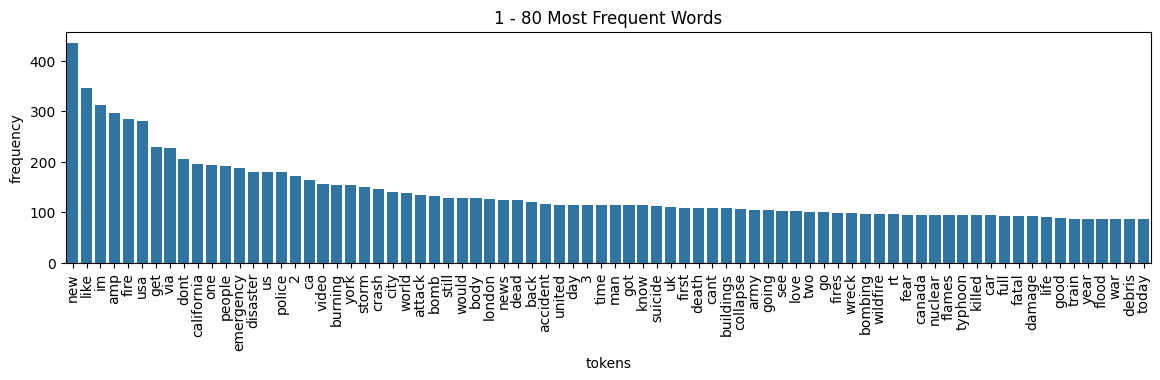

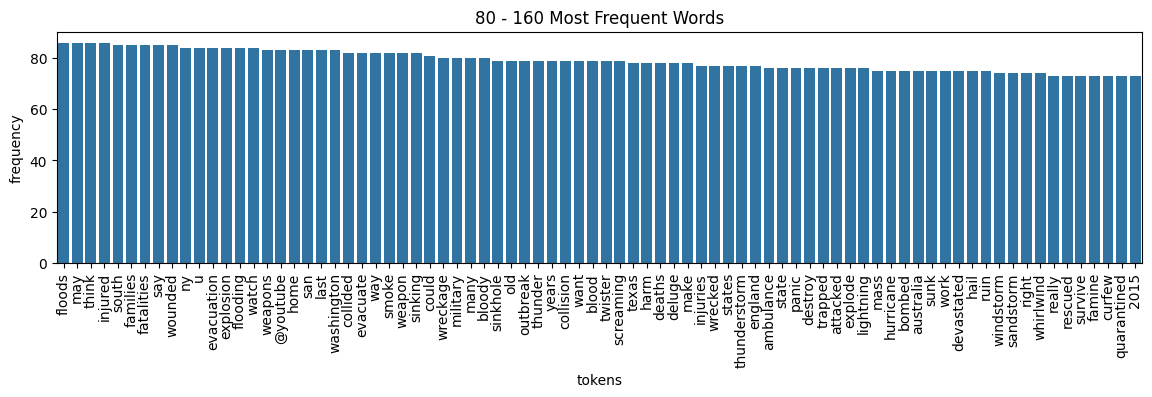

In [730]:
plt.subplots(figsize = (14, 3))
sns.barplot(token_freq[1:79], x = 'tokens', y = 'frequency')
plt.title('1 - 80 Most Frequent Words')
plt.xticks(rotation = 90)
plt.show()

plt.subplots(figsize = (14, 3))
sns.barplot(token_freq[79:159], x = 'tokens', y = 'frequency')
plt.title('80 - 160 Most Frequent Words')
plt.xticks(rotation = 90)
plt.show()

Now let's show the proportion of each class whose tweets contain these frequent words.

In [731]:
token_cat_freq = train.explode('tokens').groupby(['target_str', 'tokens'], as_index=True)['tokens'].count().reset_index(name = 'frequency').sort_values('frequency', ascending = False)
token_cat_freq.head(15)

,target_str,tokens,frequency
24923,Not Disaster,na,1459
9598,Disaster,na,1097
25018,Not Disaster,new,299
24003,Not Disaster,like,255
23138,Not Disaster,im,251
16549,Not Disaster,amp,191
4979,Disaster,fire,188
20247,Not Disaster,get,163
19020,Not Disaster,dont,152
3365,Disaster,california,147


Now that we have sorted the words and grouped by category labels, we can plot a stacked bar chart.

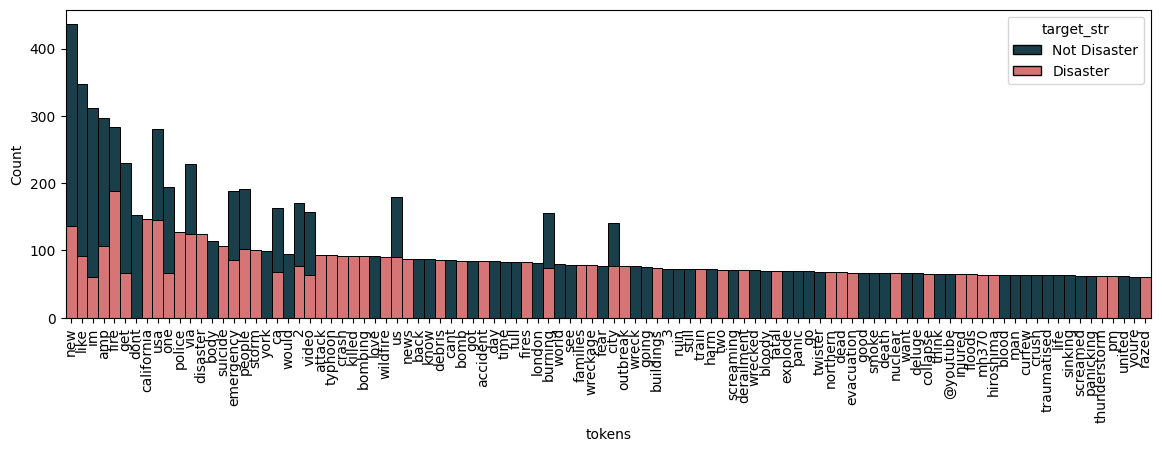

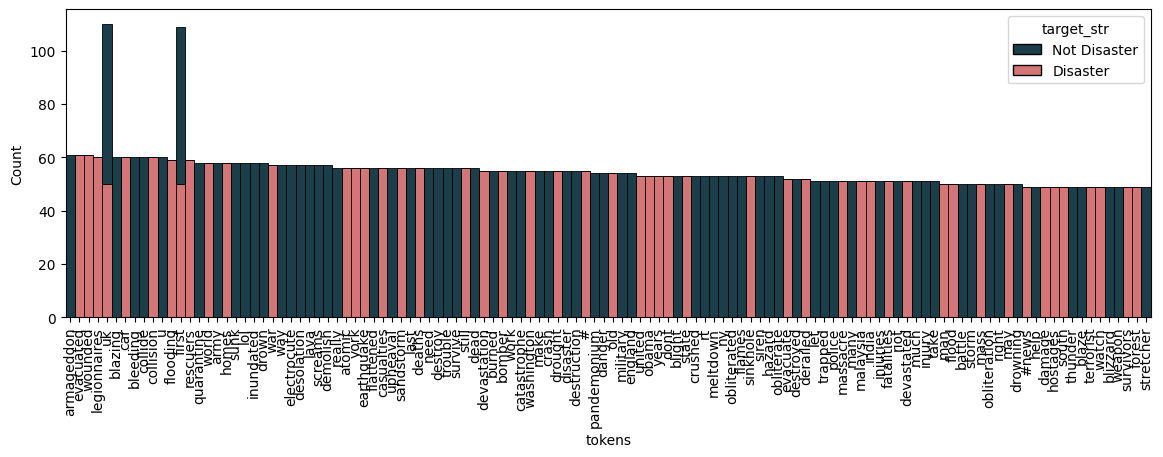

In [732]:
plt.subplots(figsize = (14, 4))
sns.histplot(token_cat_freq[2:119], x = 'tokens', weights = 'frequency', multiple = 'stack', hue = 'target_str', palette = class_cmap, alpha = 0.9)
plt.margins(x=0)
plt.xticks(rotation = 90)
plt.show()

plt.subplots(figsize = (14, 4))
sns.histplot(token_cat_freq[119:239], x = 'tokens', weights = 'frequency', multiple = 'stack', hue = 'target_str', palette = class_cmap, alpha = 0.9)
plt.margins(x=0)
plt.xticks(rotation = 90)
plt.show()

This shows a much more detailed view of which words belong to which tweet classes.

A few random examples of words that only show up in one class:

- Disaster
    - california (interesting)
    - suicide
    - disaster
    - people (interesting)
    - train
    - bomb
- Not Disaster
    - body (interesting)
    - cant
    - love
    - know
    - back

We intend to use TF-IDF and normally this means we would need to take particular care to ensure text lengths aren't too variable. The text length limitations of Twitter should help with this, but it will still be valuable to check how the distribution of each class is spread.

In [733]:
# Tweet lengths post tokenization.
train['text_len'] = train['tokens'].apply(lambda x: len(x))

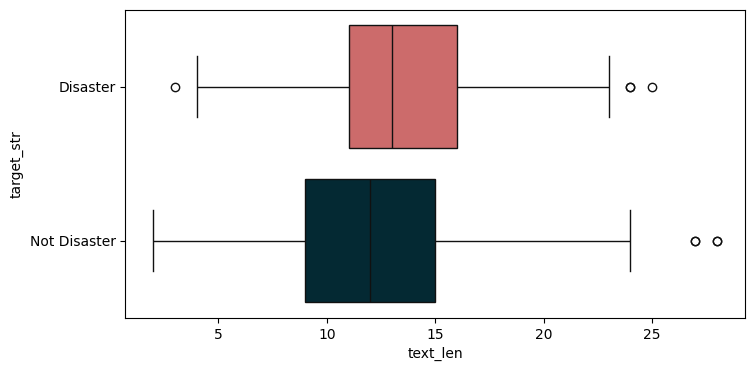

In [734]:
plt.subplots(figsize = (8, 4))
sns.boxplot(train, x = 'text_len', y = 'target_str', hue = 'target_str', palette = class_cmap, saturation = 0.9)
plt.show()

It's important to know that text_len refers to word count and not character length.

There are a few outliers here but most tweets have similar distributions. The IQR of the Disaster tweets do seem to be longer, but not significantly.

Let's test some of our previous hypotheses about tweets that contain hyperlinks, hashtags, and user tagging and see how they distribute in regards to the target variable.

 Tweets Containing Tags: 
 target_str
Not Disaster    1368
Disaster         683
Name: count, dtype: int64

 Tweets Containing Hashtags: 
 target_str
Not Disaster    898
Disaster        875
Name: count, dtype: int64

 Tweets Containing Hyperlinks: 
 target_str
Disaster        2160
Not Disaster    1794
Name: count, dtype: int64


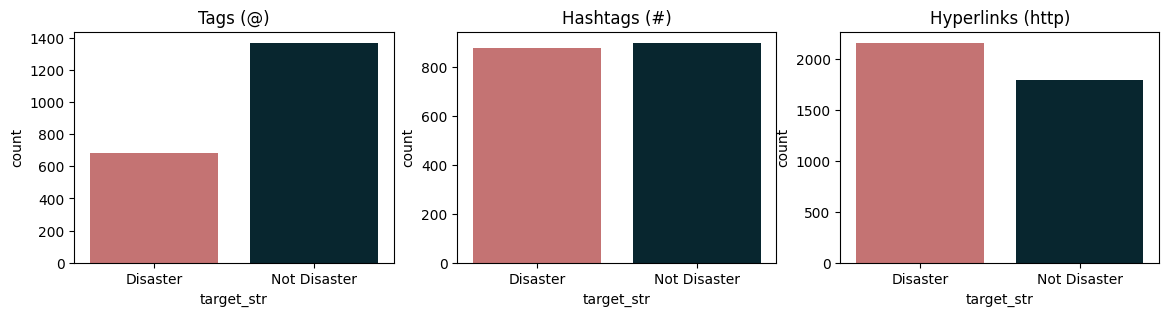

In [735]:
tweets_tagged = train.cleaned[train.cleaned.apply(lambda x: '@' in x)].index
tweets_hash = train.cleaned[train.cleaned.apply(lambda x: '#' in x)].index
tweets_http = train.cleaned[train.cleaned.apply(lambda x: 'http' in x)].index

tweets_tagged_df = train.loc[tweets_tagged]
tweets_hash_df = train.loc[tweets_hash]
tweets_http_df = train.loc[tweets_http]

print(' Tweets Containing Tags: \n', tweets_tagged_df.target_str.value_counts())
print('\n Tweets Containing Hashtags: \n', tweets_hash_df.target_str.value_counts())
print('\n Tweets Containing Hyperlinks: \n', tweets_http_df.target_str.value_counts())

fig, ax = plt.subplots(1,3, figsize = (14, 3))
sns.countplot(tweets_tagged_df, x = 'target_str', hue = 'target_str', palette = class_cmap, ax = ax[0])
ax[0].set_title('Tags (@)')
sns.countplot(tweets_hash_df, x = 'target_str', hue = 'target_str', palette = class_cmap, ax = ax[1])
ax[1].set_title('Hashtags (#)')
sns.countplot(tweets_http_df, x = 'target_str', hue = 'target_str', palette = class_cmap, ax = ax[2])
ax[2].set_title('Hyperlinks (http)')
plt.show()

Interesting, we actually see tagging people may be correlated to non-disasters and the other two are possibly insignificant. This plot alone cannot tell us this for certain though...

Let's see if tweets containing tags (@), hashtags (#), and hyperlinks (http) are statistically significant to the target class.

We can do this by performing the Chi-Squared ($\chi^2$) Test of Independence using a Contingency Table. This test examines whether two variables are related to each other (i.e. Disaster or Not vs Contains an @).

**Hypothesis Test:**

- Null Hypothesis $H_0$: The two variables are independent and the presence of @, #, or http has no effect on the target variable.
- Null Hypothesis $H_1$: The two variables are NOT independent.

- Test Statistic Equation:
    - $X^2 = \sum \frac{(O_i - E_i)^2}{E_i}$
    - Where:
        - $O_i =$ observed frequency.
        - $E_i =$ expected frequency, assuming the null hypothesis is true.

- Set Significance Level:
    - $\alpha = 0.05$

In [736]:
import statsmodels.api as sm
from scipy.stats import chi2

In [737]:
# First let's create a column that denotes whether a tweet contains the variables in question.
train['@'] = 0
train['@'] = train['@'].mask(train.cleaned.apply(lambda x: '@' in x), other = 1)
train['#'] = 0
train['#'] = train['#'].mask(train.cleaned.apply(lambda x: '#' in x), other = 1)
train['http'] = 0
train['http'] = train['http'].mask(train.cleaned.apply(lambda x: 'http' in x), other = 1)

Now to create the contingency tables.

In [738]:
cont_table_tag = pd.crosstab(train.target_str, train['@'])
display(cont_table_tag)

cont_table_hash = pd.crosstab(train.target_str, train['#'])
display(cont_table_hash)

cont_table_http = pd.crosstab(train.target_str, train['http'])
display(cont_table_http)

@,0,1
target_str,,
Disaster,2553,683
Not Disaster,2948,1368


#,0,1
target_str,,
Disaster,2361,875
Not Disaster,3418,898


http,0,1
target_str,,
Disaster,1076,2160
Not Disaster,2522,1794


Find the expected values of each frequency counts.

In [739]:
n_tag = cont_table_tag.sum()
n_disaster = cont_table_tag.sum(axis = 1)
expected_tag = np.array([[n_tag.iloc[0] * n_disaster.iloc[0] / n_tag.sum(), n_tag.iloc[1] * n_disaster.iloc[0] / n_tag.sum()],
                         [n_tag.iloc[0] * n_disaster.iloc[1] / n_tag.sum(), n_tag.iloc[1] * n_disaster.iloc[1] / n_tag.sum()]])

n_hash = cont_table_hash.sum()
n_disaster = cont_table_hash.sum(axis = 1)
expected_hash = np.array([[n_hash.iloc[0] * n_disaster.iloc[0] / n_hash.sum(), n_hash.iloc[1] * n_disaster.iloc[0] / n_hash.sum()],
                          [n_hash.iloc[0] * n_disaster.iloc[1] / n_hash.sum(), n_hash.iloc[1] * n_disaster.iloc[1] / n_hash.sum()]])

n_http = cont_table_http.sum()
n_disaster = cont_table_http.sum(axis = 1)
expected_http = np.array([[n_http.iloc[0] * n_disaster.iloc[0] / n_http.sum(), n_http.iloc[1] * n_disaster.iloc[0] / n_http.sum()],
                          [n_http.iloc[0] * n_disaster.iloc[1] / n_http.sum(), n_http.iloc[1] * n_disaster.iloc[1] / n_http.sum()]])
display(expected_tag)
display(expected_hash)
display(expected_http)

array([[2357.15519068,  878.84480932],
       [3143.84480932, 1172.15519068]])

array([[2476.27701271,  759.72298729],
       [3302.72298729, 1013.27701271]])

array([[1541.72775424, 1694.27224576],
       [2056.27224576, 2259.72775424]])

Then, calculate the test statistic and apply it to the $\chi^2$ probability density function to get a p-value.

In [740]:
t_stat_tag = np.sum(((cont_table_tag.to_numpy() - expected_tag)**2) / expected_tag) 
print('@ (Tag) Test Stat is:', t_stat_tag)

t_stat_hash = np.sum(((cont_table_hash.to_numpy() - expected_hash)**2) / expected_hash) 
print('# (Hashtag) Test Stat is:', t_stat_hash)

t_stat_http = np.sum(((cont_table_http.to_numpy() - expected_http)**2) / expected_http) 
print('http Test Stat is:', t_stat_http)

@ (Tag) Test Stat is: 104.83657413322237
# (Hashtag) Test Stat is: 39.996316108616085
http Test Stat is: 470.17811487633026


These are all fairly large. We can now either compare the test statistic to the critical value or calculate the p-value.

We will calculate the p-value since all these test statistics seem sufficiently far and likely are quite distant to the critical values.

First we need the degrees of freedom. This will be the same for each hypothesis test so I will only calculate it once.

$\text{Degrees of Freedom} = (n_{rows} - 1)(n_{columns} - 1)$

In [741]:
df = (2-1) * (2-1)

In [742]:
alpha = 0.05

pval_tag = chi2.pdf(t_stat_tag, df)
pval_hash = chi2.pdf(t_stat_hash, df)
pval_http = chi2.pdf(t_stat_http, df)

for name, pval in {'@':pval_tag, '#':pval_hash, 'http':pval_http}.items():
    print(f'{name}: p-value = {pval}')
    if pval < alpha:
        print(f"{'   -':5} Reject the hypothesis test: The two variables are NOT independent.")
    else:
        print(f"{'   -':5} FAIL to reject the hypothesis test: The two variables are independent.")

@: p-value = 6.69392483907647e-25
   -  Reject the hypothesis test: The two variables are NOT independent.
#: p-value = 1.3025979145436482e-10
   -  Reject the hypothesis test: The two variables are NOT independent.
http: p-value = 1.4685828741789818e-104
   -  Reject the hypothesis test: The two variables are NOT independent.


*Note: I could have used statsmodels' .test_nominal_association() or scipy's chi2_contingency() functions for a much quicker result, but this was a good exercise.*

Let's include here a nice and quick qualitative analysis -- a word cloud.

In [743]:
# Create gradient color maps for each category to keep with the category color scheme.
# Each column in the array is RGB-Alpha values (in that order).
# RGB values are input as a fraction to fit between 0-1.
# Each row is the next value in the gradient, using linspace to go from each
# category's color to white (256,256,256,1)

n = 256
# Business
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(1/256, 1, n)
vals[:, 1] = np.linspace(42/256, 1, n)
vals[:, 2] = np.linspace(54/256, 1, n)
cmp_business = ListedColormap(vals)

# Tech
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(209/256, 1, n)
vals[:, 1] = np.linspace(102/256, 1, n)
vals[:, 2] = np.linspace(102/256, 1, n)
cmp_tech = ListedColormap(vals)

# Create dictionary to call during plotting.
class_cmap_gradient = dict(zip(class_cmap.keys(), [cmp_business, cmp_tech]))

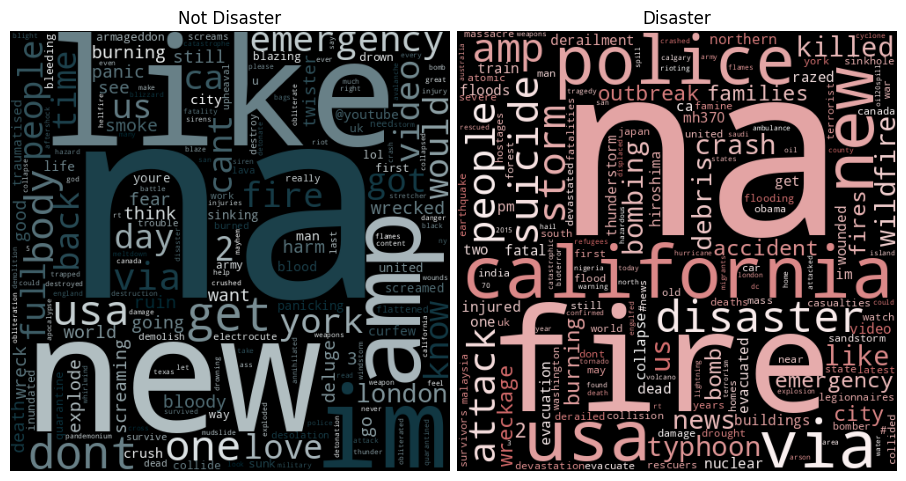

In [744]:
fig, ax = plt.subplots(1, 2, figsize = (9, 14), sharey = False, sharex = False)
for i, cat in enumerate(class_cmap.keys()):
    cloud = WordCloud(width = 500, height = 500, min_font_size = 8, colormap = class_cmap_gradient[cat])
    cloud.generate_from_frequencies(
        token_cat_freq[token_cat_freq['target_str'] == cat][['tokens', 'frequency']].set_index('tokens').to_dict()['frequency'])
    ax[i].imshow(cloud)
    ax[i].axis('off')
    ax[i].set_title(cat)

plt.tight_layout(pad = 0.5)

Similar to the frequency plots this is shows some really interesting results.

Some notable observations include:

**Not Disaster:**

Mostly expected here but some very unexpected inclusions. However, with more thought many people misidentify emergency situations and likely even more so on the internet.

- fire: surprising to see it included here.
- emergency: same as fire.
- like: is the most common word in this class.
- im: also very common.
- deluge

**Disaster:**

Lots of expected terms here but has some common words to the Not Disaster class.

- fire: very common here.
- california: still not sure what happened here but possibly fires.
- police
- via: interesting to see such an interstitial word being represented as a class marker here.

###### [Back to Table of Contents](#toc)

## 5. Models and Embedding <a name="models"></a>

---

### 5.1. Baseline Models <a name="baseline"></a>

It's always important to set a suitable baseline for comparison.

The first baseline model is simple, equal random chance at selecting any of the tweet classes.

In [162]:
mod_rand_baseline = 1 / len(train.target.unique()) # 1/2
print('Random Baseline F1-Score:', mod_rand_baseline)

Random Baseline F1-Score: 0.5


The next option is taking the most frequent class in the dataset and always predict that class.

*Note: The y predictions will be submitted to Kaggle to receive the accuracy score and posted here*

In [169]:
most_freq_cat = train.target.value_counts(sort = True).index[0]
mod_freq_array = np.full(shape = len(X_test), fill_value = most_freq_cat)

y_pred_freq_baseline = X_test[['id']].copy()
y_pred_freq_baseline['target'] = mod_freq_array
y_pred_freq_baseline.to_csv(current_wdir + f'/Models/Frequency_Baseline/X_test_Submission_Freq_Baseline.csv', index = False)
display(y_pred_freq_baseline)

mod_freq_baseline = 0.57033
print('Most Frequent Category Baseline F1-Score:', mod_freq_baseline)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


Most Frequent Category Baseline F1-Score: 0.57033


In this case the most frequent class label in the training data is `Not Disaster` or `0`.

F1-Score $\approx{0.57}$ for predicting only the most frequent category in the training data is pretty reasonable for a simple baseline test.

This result beats the random chance baseline of 50% so will be used to compare all subsequent models.

###### [Back to Table of Contents](#toc)

### 5.2. Word Embedding <a name="embed"></a>

Next, we need a way to embed our corpus through a vectorization technique.

**Term Frequency-Inverse Document Frequency (TF-IDF):**

TF-IDF logarithmically scales an inverse fraction of number of documents divided by the number of documents containing each word. This effectively gives a measure of how much information each word holds in each document.

When fitting and transforming the training data into a TF-IDF sparse matrix, it needs to be mentioned that no test data text should be included in the fitting process. Like any other modeling process, this would constitute as data leakage and all evaluations would be meaningless. To ensure no data leakage occurs any time text data is being processed into a sparse matrix, the function `.transform()` (not `.fit_transform()`) will be used on a fitted TF-IDF object.

*Note: One issue that can potentially arise when using TF-IDF is if article lengths are highly variable, giving more weight to words contained in longer articles. However, as we saw during EDA this, mostly, shouldn't be the case in this dataset.*

In [30]:
def tf_vectorize(X_train, params):
    '''
    Takes a X_train dataframe and parameter grid to .fit_transform() the TfidVectorizer().
    Parameters:
        X_train: Dataframe of X training data.
        params: Dictionary of parameters in the form: {'Name':[Value]}
    Returns:
        tfidf: Fitted TF-IDF object.
        X_train_sparse: Transformed X_train into sparse matrix.
    '''
    tfidf = TfidfVectorizer(min_df = params['min_df'], # ignore terms that have a document frequency strictly LOWER than the given threshold
                            max_df = params['max_df'], # ignore terms that have a document frequency strictly HIGHER than the given threshold
                            norm = params['norm'], 
                            stop_words = None, # Already removed.
                            ngram_range = params['ngram_range'])
    # Fit and create sparse matrix.
    X_train_sparse = tfidf.fit_transform(X_train)

    return (tfidf, X_train_sparse)

###### [Back to Table of Contents](#toc)

### 5.3. Unsupervised Model <a name="unsuper"></a>

#### 5.3.1. Non-Negative Matrix Factorization (NMF) <a name="nmf"></a>

In NMF we take a non-negative value matrix ($\bf{V}$) and factorize it into two matrices, conventionally labeled $\bf{W}$ and $\bf{H}$ which decomposes $\bf{V}$ into matrices of weights and latent features, essentially ranking each feature. This approximation is done through several different cost functions and regularization techniques.

Since we have labels that we are hold back from the unsupervised model, we do not have a way to to be able to evaluate the accuracy of the model yet. A function needs to be implemented to find and map the label order from the output predictions back to the ground truth.

In [31]:
def label_permute_accuracy(df, y_pred, n = 5):
    """
    Calculates all permutations of class labels and tests accuracy of each one. 
    Saves the highest accuracy and associated label order as being the true label order.
    Parameters:
        df: Dataframe containing category labels.
        y_pred: Class label prediction flat array or series.
    Returns: 
        Permuted label order and accuracy score.
        Example: (0, 4, 1, 2, 3), 0.95
    """
        
    label_list = df['Category'].unique()
    labels = {key : i for i, key in enumerate(label_list)}
    order_perms = list(itertools.permutations(range(0, n)))

    acc = float('-inf')
    label_order = None

    # Iterate through order permutations.
    for i_order in order_perms:
        # Assign label dictionary new order permutation.
        for i, key in enumerate(labels.keys()):
            labels[key] = i_order[i]

        # Map new permutation to classes in DF.
        # Calculate accuracy for this permutation.
        # Only calculating simple accuracy, not per class.
        df['class_perm'] = df['Category'].map(labels)
        perm_acc = accuracy_score(y_true = df['class_perm'], y_pred = y_pred)

        # Check if this permutation accuracy is better than last best.
        if perm_acc > acc:
            acc = perm_acc
            label_order = i_order

    return (label_order, acc)

Create sparse matrix of Articles x Tokens using TF-IDF.

In [32]:
# Parameters will be optimized in the following section.
params_tf = {'min_df' : 1, 
          'max_df' : 0.2,
          'norm' : 'l2', 
          'ngram_range' : (1, 1)}

tfidf, X_train_sparse_nmf = tf_vectorize(train['cleaned'], params_tf)

Finally, we are ready to fit the NMF model.

In [33]:
# Parameters will be optimized in the next step.
mod_nmf = NMF(n_components = 5, 
              init = None, 
              solver = 'mu', 
              beta_loss = 'kullback-leibler',
              tol = 0.0001,
              max_iter = 200,
              random_state = 11,
              l1_ratio = 0,
              verbose = 0)
mod_nmf_train = mod_nmf.fit_transform(X_train_sparse_nmf)

print(X_train_sparse_nmf.shape, '- Articles X Tokens | Sparse Matrix Shape')
print(mod_nmf_train.shape, '- Articles X Topics | NMF Weights Matrix Shape')
print(mod_nmf.components_.shape, '- Topics X Tokens | NMF Components Matrix Shape')

mod_nmf_train_y_pred = mod_nmf_train.argmax(axis = 1) # Some rows have more than one non-zero.
labelorder, acc = label_permute_accuracy(train, mod_nmf_train_y_pred)

# Map best accuracy permutation order and predictions to dataframe.
labels = {key : i for i, key in zip(labelorder, train['Category'].unique())}
train['class_perm'] = train['Category'].map(labels)

(1440, 25084) - Articles X Tokens | Sparse Matrix Shape
(1440, 5) - Articles X Topics | NMF Weights Matrix Shape
(5, 25084) - Topics X Tokens | NMF Components Matrix Shape


Here we can see the matrix transformations done during NMF:

$\lbrack\bf{V}\rbrack \approx \lbrack\bf{W}\rbrack \cdot \lbrack\bf{H}\rbrack$

Now to plot a Confusion Matrix on training set.

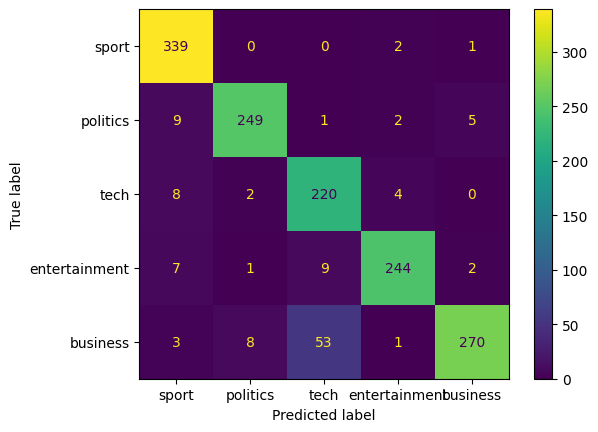

Accuracy: 0.9180555555555555


In [34]:
conf_matrix = confusion_matrix(y_true = train['class_perm'], y_pred = mod_nmf_train_y_pred)
# Need to sort labels by dictionary value to match new indexes given to categories.
# This is done in display_labels. A little convoluted but works for now.
ConfusionMatrixDisplay(conf_matrix, display_labels = {k: v for k, v in sorted(labels.items(), key = lambda item: item[1])}).plot()
plt.show()

print('Accuracy:', accuracy_score(y_true = train['class_perm'], y_pred = mod_nmf_train_y_pred))

For a only a few test fits 91.8% is pretty good accuracy. It still seems to have trouble classifying most categories, but especially business incorrectly being classified as a tech article.

Now, it is time to optimize not only the NMF model, but also TF-IDF. 

*Note: This is a time intensive process so the results will be saved into a .csv file so this code block can be commented out for future runs.*

In [35]:
def model_optimizer_nmf(param_grid, train_df, k_folds = 3):
    '''
    Takes a parameter grid to optimize TF-IDF and NMF through K-Fold cross validation.
    This results in permutations(parameters) * k_folds models being fit.
    Parameters:
        param_grid: Dictionary of parameters in the form: {'Name':[Value]}
        train_df: Dataframe of training data.
    Returns:
        opt_params: Dictionary of parameters with highest mean accuracy during validation.
        opt_label_order: Label order of highest accuracy permutation.
        opt_acc: Highest mean validation accuracy.
        opt_df: Dataframe of all results.
    '''
    # Find all parameter permutations
    params_permut = list(itertools.product(*param_grid.values()))  
    print(f'The number of parameter combinations to be tested: {len(params_permut)}')
    print(f'The number of models tested with cross-validation: {len(params_permut) * k_folds}')

    # Initialize optimized variables.
    opt_array = np.full((len(params_permut) * k_folds, len(param_grid) + 4), fill_value = np.nan, dtype = 'O')
    opt_acc = float('-inf')
    opt_label_order = None
    opt_params = None

    # A K-Fold method will be used to split the training set into training and validation sets.
    cross_val = KFold(n_splits = k_folds, shuffle = True)

    # Loop through each parameter permutation.
    for i, par in enumerate(params_permut):
        current_params = dict(zip(param_grid.keys(), par))
        if i % 100 == 0:
            print('Current Combo:', i+1, '| Params:', current_params)
        # Handle some incompatible combinations of parameters.
        if (current_params['solver'] == 'cd') and (current_params['beta_loss'] == 'kullback-leibler'):
            continue # Skip loop
        if (current_params['solver'] == 'mu') and (current_params['init'] == 'nndsvd'):
            continue # Skip loop
        
        # Holds each fold's accuracy to be averaged after.
        fold_accuracy = []

        for train_index, val_index in cross_val.split(train_df):
            train_fold = train_df.iloc[train_index].copy()
            val_fold = train_df.iloc[val_index].copy()

            # TF-IDF
            tfidf, X_train_sparse_nmf = tf_vectorize(train_fold['cleaned'], current_params)
            X_val_sparse_nmf = tfidf.transform(val_fold['cleaned'])

            # NMF
            mod_nmf = NMF(n_components = 5, 
                        init = current_params['init'], 
                        solver = current_params['solver'], 
                        beta_loss = current_params['beta_loss'],
                        tol = 0.000001,
                        max_iter = 500,
                        random_state = 11,
                        l1_ratio = current_params['l1_ratio'],
                        verbose = 0)

            mod_nmf_train = mod_nmf.fit_transform(X_train_sparse_nmf)
            mod_nmf_val = mod_nmf.transform(X_val_sparse_nmf)
            mod_nmf_train_y_pred = mod_nmf_train.argmax(axis = 1)
            mod_nmf_val_y_pred = mod_nmf_val.argmax(axis = 1)
            
            label_order, acc = label_permute_accuracy(val_fold, mod_nmf_val_y_pred)
            fold_accuracy.append(acc)

        # Average and calculate results.
        avg_acc = np.mean(fold_accuracy)
        model_results = list(par) + fold_accuracy + [avg_acc]
        opt_array[i] = model_results
        #print(f'Average accuracy for params {current_params}: {avg_acc}')
        
        if avg_acc > opt_acc:
            opt_acc = avg_acc
            opt_label_order = label_order
            opt_params = current_params
            print('   Accuracy Increased!!!', opt_acc, 'Current Combo:', i+1, '| Params:', current_params)

    print(f'Optimized Model:\n  Parameters - {opt_params}\n  Label Order - {opt_label_order}\n  Cross-Val Accuracy - {opt_acc}')
    # Save results to csv.
    column_names = list(param_grid.keys()) + ['val_acc_1','val_acc_2','val_acc_3','val_acc_avg']
    opt_df = pd.DataFrame(opt_array, columns = column_names)
    opt_df.to_csv(current_wdir + f'/Models/NMF/Optimization_Results.csv.gz', compression = 'gzip', index = False)

    return (opt_params, opt_label_order, opt_acc, opt_df)

In [36]:
# Comment out after running. Results are saved in function call and can be loaded in next code block.
# Optimization Grid
# param_grid = {'min_df' : [1,2,3,10],
#               'max_df' : np.linspace(0.2,0.8,4),
#               'norm' : ['l1','l2'],
#               'ngram_range' : [(1,1),(1,2),(1,3)],
#               'init' : ['nndsvd','nndsvda'],
#               'solver' : ['cd','mu'],
#               'beta_loss' : ['frobenius','kullback-leibler'],
#               'l1_ratio' : np.linspace(0,1,5)}

# opt_params, opt_label_order, opt_acc, opt_df = model_optimizer_nmf(param_grid = param_grid, train_df = train, k_folds = 3)

The number of parameter combinations to be tested: 3840
The number of models tested with cross-validation: 11520
Current Combo: 1 | Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
   Accuracy Increased!!! 0.9083333333333333 Current Combo: 1 | Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
   Accuracy Increased!!! 0.9249999999999999 Current Combo: 2 | Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.25}
   Accuracy Increased!!! 0.9270833333333334 Current Combo: 5 | Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 1.0}
   Accuracy Increased!!! 0.9298611111111111 Current Combo: 31 | Params: {'

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


   Accuracy Increased!!! 0.9534722222222222 Current Combo: 398 | Params: {'min_df': 1, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvda', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.5}
Current Combo: 401 | Params: {'min_df': 1, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 501 | Params: {'min_df': 1, 'max_df': 0.6000000000000001, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Combo: 601 | Params: {'min_df': 1, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
   Accuracy Increased!!! 0.9541666666666666 Current Combo: 640 | Params: {'min_df': 1, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvda', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 1.0}
Current Combo: 701 | Params: {'min_df': 1, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 3), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Combo: 801 | Params: {'min_df': 1, 'max_df': 0.8, 'norm': 'l1', 'ngram_range': (1, 3), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 901 | Params: {'min_df': 1, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 1001 | Params: {'min_df': 2, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
   Accuracy Increased!!! 0.9576388888888889 Current Combo: 1036 | Params: {'min_df': 2, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvda', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.0}
   Accuracy Increased!!! 0.9597222222222223 Current Combo: 1037 | Params: {'min_df': 2, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvda', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.25}
   Accuracy Increased!!! 0.9618

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Combo: 2001 | Params: {'min_df': 3, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 3), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 2101 | Params: {'min_df': 3, 'max_df': 0.2, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 2201 | Params: {'min_df': 3, 'max_df': 0.4, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Combo: 2301 | Params: {'min_df': 3, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 2401 | Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 2501 | Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l1', 'ngram_range': (1, 3), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 2601 | Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 3), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 2701 | Params: {'min_df': 3, 'max_df': 0.8, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 2801 | Params: {'min_df': 3, 'max_df': 0.8, 'norm': 'l2', 'ngram_range':

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Combo: 3201 | Params: {'min_df': 10, 'max_df': 0.4, 'norm': 'l1', 'ngram_range': (1, 3), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 3301 | Params: {'min_df': 10, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 3401 | Params: {'min_df': 10, 'max_df': 0.6000000000000001, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 3501 | Params: {'min_df': 10, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 3601 | Params: {'min_df': 10, 'max_df': 0.8, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 3701 | Params: {'min_df': 10, 'max_df': 0.8, 'norm': 'l1', 'ngram_range': (1, 3), '

In [37]:
# Load and read in previously saved optimizations.
file = current_wdir + f'/Models/NMF/Optimization_Results.csv.gz'
opt_df = pd.read_csv(file, compression = 'gzip')
opt_df = opt_df.dropna()
# min_df should be an int otherwise means proportion as float.
opt_df.min_df = opt_df.min_df.astype(int)
# Find best cross-val score and cast parameters to dictionary.
opt_params = opt_df.sort_values(by = 'val_acc_avg', ascending=False).iloc[1,:8].to_dict()
# This is ugly but converting string to tuple.
convert_tuple = opt_params['ngram_range']
convert_tuple = tuple(map(int, convert_tuple.strip('()').split(',')))
opt_params['ngram_range'] = convert_tuple
opt_params

{'min_df': 3,
 'max_df': 0.4,
 'norm': 'l2',
 'ngram_range': (1, 3),
 'init': 'nndsvda',
 'solver': 'mu',
 'beta_loss': 'kullback-leibler',
 'l1_ratio': 0.25}

Now to refit NMF with optimized parameters.

*Note: The optimized TF-IDF parameters will remain the same for the rest of this project.*

In [38]:
def nmf_fit_optimized(X_train, verbose = False):

    tfidf, X_train_sparse_nmf = tf_vectorize(X_train, opt_params)

    mod_nmf = NMF(n_components = 5, 
                init = opt_params['init'], 
                solver = opt_params['solver'], 
                beta_loss = opt_params['beta_loss'],
                tol = 0.000001,
                max_iter = 500,
                random_state = 11,
                l1_ratio = opt_params['l1_ratio'],
                verbose = 0)
    mod_nmf_train = mod_nmf.fit_transform(X_train_sparse_nmf)
    mod_nmf_train_y_pred = mod_nmf_train.argmax(axis = 1)

    if verbose == True:
        print(f'Modeling using optimized parameters:\n {opt_params}')
        print(X_train_sparse_nmf.shape, '- Articles X Tokens | Sparse Matrix Shape')
        print(mod_nmf_train.shape, '- Articles X Topics | NMF Weights Matrix Shape')
        print(mod_nmf.components_.shape, '- Topics X Tokens | NMF Components Matrix Shape')

    return (tfidf, X_train_sparse_nmf, mod_nmf, mod_nmf_train_y_pred)

In [39]:
tfidf, train_sparse_embed_nmf, mod_nmf, mod_nmf_train_y_pred = nmf_fit_optimized(train['cleaned'], verbose = True)
label_order, acc = label_permute_accuracy(train, mod_nmf_train_y_pred)

# Map best accuracy permutation order and predictions to dataframe.
labels = {key : i for i, key in zip(label_order, train['Category'].unique())}
train['class_perm'] = train['Category'].map(labels)

Modeling using optimized parameters:
 {'min_df': 3, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 3), 'init': 'nndsvda', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.25}
(1440, 22830) - Articles X Tokens | Sparse Matrix Shape
(1440, 5) - Articles X Topics | NMF Weights Matrix Shape
(5, 22830) - Topics X Tokens | NMF Components Matrix Shape


Confusion Matrix on training set.

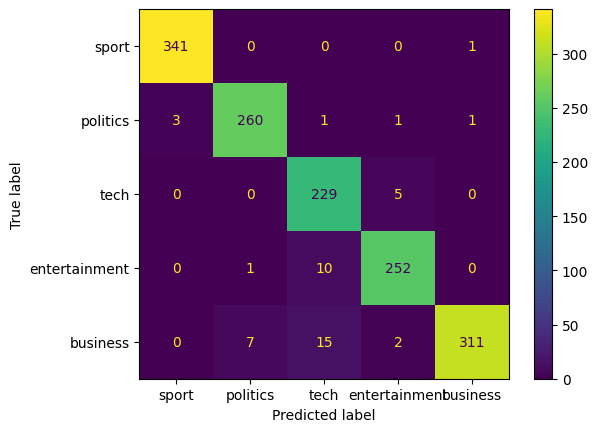

Accuracy: 0.9673611111111111


In [40]:
conf_matrix = confusion_matrix(y_true = train['class_perm'], y_pred = mod_nmf_train_y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = {k: v for k, v in sorted(labels.items(), key = lambda item: item[1])}).plot()
plt.show()

print('Accuracy:', accuracy_score(y_true = train['class_perm'], y_pred = mod_nmf_train_y_pred))

Here we will predict on the Test set. Results can be found in the conclusion section.

In [41]:
X_test_sparse_nmf = tfidf.transform(X_test['cleaned'])
mod_nmf_X_test = mod_nmf.transform(X_test_sparse_nmf)
y_pred_nmf = mod_nmf_X_test.argmax(axis = 1)

# Map best accuracy permutation order and predictions to dataframe.
labels_test = {key : i for i, key in zip(train['Category'].unique(), label_order)}
X_test['y_pred'] = y_pred_nmf
X_test['Category'] = X_test['y_pred'].map(labels_test)

# Output test results for kaggle submission scoring.
X_test[['ArticleId', 'Category']].to_csv(current_wdir + f'/Models/NMF/X_test_Submission_NMF.csv', index = False)

This is a good time to take a more detailed look at the optimization results to which parameters were the most relevant with NMF and this dataset.

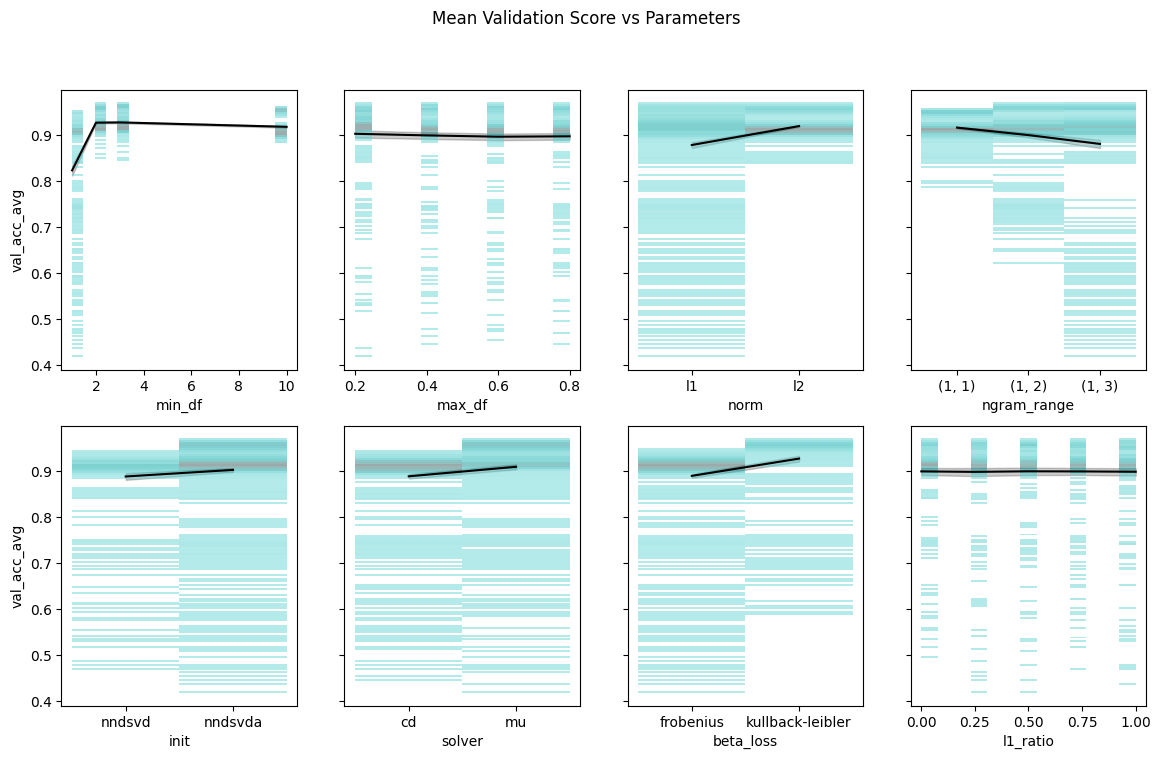

In [42]:
fig, ax = plt.subplots(2, int(len(opt_params) / 2), figsize = (14, 8), sharey = True)

for i, col in enumerate(opt_params.keys()):
    sns.lineplot(data = opt_df, ax = ax[i//4, i%4], x = col, y = 'val_acc_avg', estimator = 'mean', color = 'black')
    sns.histplot(data = opt_df, ax = ax[i//4, i%4], x = col, y = 'val_acc_avg', color = 'teal', alpha = 0.5)
fig.suptitle('Mean Validation Score vs Parameters')
plt.show()

This plot is admittedly limited in it use because it doesn't show how each parameter works in combination with changes in the others. 

That being said, it does gives a decent view of how each singular parameter change might affect accuracy and what the distribution of scores looks like with that selected parameter.

Notable observations:
- `ngram_range` the distribution of accuracy scores widens as you add bigrams and trigrams, requiring more tuning, but with that tuning gains a little in accuracy. This fact wouldn't be noticeable when solely looking at the averaged line plot.
- `init`, `solver`, `beta-loss` all show one of their parameters (each on the right on this plot) performing better than the other. We would expect to see the best performing models to all use `nndsvda`, `mu`, and `kullback-leibler` respectively.
- `max_df` surprisingly shows fairly even distributions across parameter changes. Intuition during initial fit is that this is an important parameter because it removes words that all articles share at different proportion thresholds, which essentially removes noise. The even distribution of accuracy scores indicates to me that this parameter, while important, also heavily relies on other parameter's tuning, or more values near the end range should be tested (0.05-0.2 and/or 0.8-0.95).
- `min_df` shows a very clear picture, gaining accuracy score at the value of 3. It exhibits a slight slope downward towards 10, which still shows decent accuracy score. Exploring more values above 10 may be useful in the future.

Now let's sort the optimization results dataframe by average validation accuracy to see if these observations hold true.

In [43]:
opt_df.sort_values(by = 'val_acc_avg', ascending = False).head(15)

,min_df,max_df,norm,ngram_range,init,solver,beta_loss,l1_ratio,val_acc_1,val_acc_2,val_acc_3,val_acc_avg
1558,2,0.6,l1,"(1, 3)",nndsvda,mu,kullback-leibler,0.75,0.970833,0.968750,0.975000,0.971528
2396,3,0.4,l2,"(1, 3)",nndsvda,mu,kullback-leibler,0.25,0.968750,0.964583,0.975000,0.969444
2477,3,0.6,l1,"(1, 2)",nndsvda,mu,kullback-leibler,0.50,0.966667,0.977083,0.964583,0.969444
1795,2,0.8,l1,"(1, 3)",nndsvda,mu,kullback-leibler,0.00,0.966667,0.968750,0.968750,0.968056
2399,3,0.4,l2,"(1, 3)",nndsvda,mu,kullback-leibler,1.00,0.966667,0.960417,0.975000,0.967361
2118,3,0.2,l2,"(1, 2)",nndsvda,mu,kullback-leibler,0.75,0.966667,0.970833,0.964583,0.967361
1199,2,0.2,l2,"(1, 3)",nndsvda,mu,kullback-leibler,1.00,0.966667,0.977083,0.958333,0.967361
2038,3,0.2,l1,"(1, 3)",nndsvda,mu,kullback-leibler,0.75,0.966667,0.954167,0.979167,0.966667
2397,3,0.4,l2,"(1, 3)",nndsvda,mu,kullback-leibler,0.50,0.964583,0.962500,0.972917,0.966667
2515,3,0.6,l1,"(1, 3)",nndsvda,mu,kullback-leibler,0.00,0.956250,0.964583,0.979167,0.966667


This looks almost exactly as expected from the plot. 

There also appears to be a tie for the best model parameters with differences in `max_df`, `norm`, `ngram_range`. The code uses greater than to find the optimized results so the first encountered combination was what has been used. In this case the model in the 2nd row. It would be worth seeing how the other model performs as well since it includes trigrams and uses l2 normalization.

###### [Back to Table of Contents](#toc)

### 5.4. Deep Learning <a name="deep"></a>

#### 5.4.1. Recurrent Neural Network (RNN) <a name="rnn"></a>

###### [Back to Table of Contents](#toc)

  #### 5.4.2. Long Short Term Memory (LSTM) <a name="lstm"></a>

###### [Back to Table of Contents](#toc)

## 6. Results <a name="results"></a>

---

In [88]:
# Highlight the best model's test results green at each proportion.
def max_value_highlight(df, train = True):
    # Hard coding the test rows because creating a boolean mask
    # that works with the styler and conditioning on multiindex is a nightmare.
    if train == False: # Don't omit rows.
        max_test_rows = df.max()
    else:
        max_test_rows = df.iloc[[1,3,5]].max()
    is_max = (df == max_test_rows)
    
    return ['background-color:green' if v else '' for v in is_max]

# Highlight the top two results in each column blue so that 2nd place is in blue after .apply().
def highlight_top_two(df, train = True):
    # Sort values
    if train == False: # Don't omit rows.
        test_rows = df
    else:
        test_rows = df.iloc[[1,3,5]]
    sorted_df = test_rows.sort_values(ascending = False)
    top_two = sorted_df.iloc[: 2]
    # Mask
    is_top_two = df.isin(top_two)

    return ['background-color: blue' if v else '' for v in is_top_two]

###### [Back to Table of Contents](#toc)

## 7. Conclusion - Kaggle Submission Test Set <a name="conclusion"></a>

---

### 7.1. Possible Areas for Improvement <a name="improvements"></a>

###### [Back to Table of Contents](#toc)

## Appendix A - Online References: <a name="appendixa"></a>

Resources that helped along the way in no particular order.

1. Quick resource on stop word removal in Python - https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
2. Regex to remove extra whitespace - https://stackoverflow.com/questions/1546226/is-there-a-simple-way-to-remove-multiple-spaces-in-a-string
3. NMF - https://en.wikipedia.org/wiki/Non-negative_matrix_factorization#
4. TF-IDF - https://en.wikipedia.org/wiki/Tf%E2%80%93idf#

 Exported to HTML via command line using:

- `jupyter nbconvert BBC_News_Classification.ipynb --to html`
- `jupyter nbconvert BBC_News_Classification.ipynb --to html --HTMLExporter.theme=dark`

###### [Back to Table of Contents](#toc)